In [2]:
import sys
sys.path.append("..\\methods")

In [39]:
import os

from estnltk import Text

import json
from estnltk.converters import json_to_text

from noun_phrase_extraction import create_df
from POS_sequence import get_POS_sequence
from graph_methods import *

import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

import pandas as pd
import numpy as np

import csv

In [9]:
path = 'json_data/'

In [10]:
all_texts = []

for filename in os.listdir(path):
    file = os.path.join(path, filename)
    with open(file, 'r') as f:
        content = json.load( f )
        text = json_to_text( content )
        all_texts.append( text )

In [11]:
all_texts[0]

Text(text='ALBERT LAEGAS , Tallinn\n\nMinu arvates on parlamenti mittekuuluvate erakondade nõue korraldada uued parlamendivalimised täiesti õigel kohal .\nJärgmine samm oleks konstitutsiooniparandus , mille kohaselt saaksid parlamenti kuuluda vaid sinna mittekuuluvad parteid .\nSee tähendaks , et kõigepealt oleks valimised , misjärel kõik valimistel kaotanud jõud moodustaksid võimuloleva parlamendi .\nNii oleks Eesti valitsuses esindatud kõik vähemused : mitte ainult nö. tavalised vähemused , vaid ka tegelikud poliitilised vähemused .\n\nMinu teada pole veel ükski riik demokraatia arengus nii kaugele jõudnud .\nEesti riik peab aga sammuma esireas ja veelgi eespool .')

In [12]:
import time

beginning = time.time()

for text_id, text in enumerate(all_texts):
    df = create_df(text_id, text)

print(time.time()-beginning)

1417.999287366867


In [6]:
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,graph,graph_code,graph_code_pos,graph_code_pos_ner_timex
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,"(1, 0)","((0, 1, root))","(P,(0, 1, root))","(0,P,(0, 1, root))"
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,"(1, 2, 3, 0)","((0, 3, root),(2, 1, advmod),(3, 2, amod))","(S-D-A,(0, 3, root),(2, 1, advmod),(3, 2, amod))","(0-0-0,S-D-A,(0, 3, root),(2, 1, advmod),(3, 2, amod))"
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,"(1, 0, 2)","((0, 1, root),(1, 2, case))","(P-K,(0, 1, root),(1, 2, case))","(0-0,P-K,(0, 1, root),(1, 2, case))"
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,"(1, 0)","((0, 1, root))","(S,(0, 1, root))","(0,S,(0, 1, root))"
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,"(1, 0)","((0, 1, root))","(S,(0, 1, root))","(0,S,(0, 1, root))"
...,...,...,...,...,...,...,...,...,...,...
33734,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","((0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))","(S-P-V-A-A-S-Z-V-Z-(J|D)-P-V-S-D-S-Z-J-V-S-P-C-V,(0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))","(0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,S-P-V-A-A-S-Z-V-Z-(J|D)-P-V-S-D-S-Z-J-V-S-P-C-V,(0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))"
33735,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,"(1, 4, 2, 3, 0, 5, 6, 7, 8)","((0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))","(S-H-V-D-V-Z-S-P,(0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))","(0-ner_LOC-0-0-0-0-0-0,S-H-V-D-V-Z-S-P,(0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))"
33736,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,"(1, 2, 0, 3)","((0, 2, root),(2, 1, cc),(2, 3, punct))","(S-J-Z,(0, 2, root),(2, 1, cc),(2, 3, punct))","(0-0-0,S-J-Z,(0, 2, root),(2, 1, cc),(2, 3, punct))"
33737,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","((0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))","(S-P-K-V-P-V-Z-D-V-Z-J-P,(0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))","(0-0-0-0-0-0-0-0-0-0-0-0,S-P-K-V-P-V-Z-D-V-Z-J-P,(0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))"


### POS-märgendite järjestused

Lisame kõik sõnaliigijärjestused DataFrame-i:

In [14]:
all_pos = []
for phrase in df['phrase']:
    all_pos.append(get_POS_sequence(phrase))
df.insert(len(df.columns), 'pos_sequence', all_pos)

In [8]:
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence,graph,graph_code,graph_code_pos,graph_code_pos_ner_timex
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,P,"(1, 0)","((0, 1, root))","(P,(0, 1, root))","(0,P,(0, 1, root))"
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,D-A-S,"(1, 2, 3, 0)","((0, 3, root),(2, 1, advmod),(3, 2, amod))","(S-D-A,(0, 3, root),(2, 1, advmod),(3, 2, amod))","(0-0-0,S-D-A,(0, 3, root),(2, 1, advmod),(3, 2, amod))"
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,P-K,"(1, 0, 2)","((0, 1, root),(1, 2, case))","(P-K,(0, 1, root),(1, 2, case))","(0-0,P-K,(0, 1, root),(1, 2, case))"
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,S,"(1, 0)","((0, 1, root))","(S,(0, 1, root))","(0,S,(0, 1, root))"
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,S,"(1, 0)","((0, 1, root))","(S,(0, 1, root))","(0,S,(0, 1, root))"
...,...,...,...,...,...,...,...,...,...,...,...
33734,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","((0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))","(S-P-V-A-A-S-Z-V-Z-(J|D)-P-V-S-D-S-Z-J-V-S-P-C-V,(0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))","(0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,S-P-V-A-A-S-Z-V-Z-(J|D)-P-V-S-D-S-Z-J-V-S-P-C-V,(0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))"
33735,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z,"(1, 4, 2, 3, 0, 5, 6, 7, 8)","((0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))","(S-H-V-D-V-Z-S-P,(0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))","(0-ner_LOC-0-0-0-0-0-0,S-H-V-D-V-Z-S-P,(0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))"
33736,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,J-S-Z,"(1, 2, 0, 3)","((0, 2, root),(2, 1, cc),(2, 3, punct))","(S-J-Z,(0, 2, root),(2, 1, cc),(2, 3, punct))","(0-0-0,S-J-Z,(0, 2, root),(2, 1, cc),(2, 3, punct))"
33737,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","((0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))","(S-P-K-V-P-V-Z-D-V-Z-J-P,(0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))","(0-0-0-0-0-0-0-0-0-0-0-0,S-P-K-V-P-V-Z-D-V-Z-J-P,(0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))"


### Süntaksipuu graafi esitus

In [16]:
test_phrase = df['phrase'][2000]

In [17]:
test_phrase.stanza_syntax

Layer(name='stanza_syntax', attributes=('id', 'lemma', 'upostag', 'xpostag', 'feats', 'head', 'deprel', 'deps', 'misc', 'parent_span', 'children'), spans=SL[Span('Indrek', [{'id': 1, 'lemma': 'Indrek', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 0, 'deprel': 'root', 'deps': '_', 'misc': '_', 'parent_span': None, 'children': <class 'tuple'>}]),
Span('ja', [{'id': 2, 'lemma': 'ja', 'upostag': 'J', 'xpostag': 'J', 'feats': OrderedDict(), 'head': 3, 'deprel': 'cc', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': ()}]),
Span('Ramilda', [{'id': 3, 'lemma': 'Ramilda', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 1, 'deprel': 'conj', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': <class 'tuple'>}]),
Span('(', [{'id': 4, 'lemma': '(', 'upostag': 'Z', 'xpostag': 'Z', 'feats': OrderedDict(), 'head': 5, 'deprel': 'punct', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': ()}]),
Span('Marika', [{'id': 5, 'lemma': 'Marika', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 3, 'deprel': 'parataxis', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': <class 'tuple'>}]),
Span('Barabantshikova', [{'id': 6, 'lemma': 'Barabantshikova', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 5, 'deprel': 'flat', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': ()}]),
Span(')', [{'id': 7, 'lemma': ')', 'upostag': 'Z', 'xpostag': 'Z', 'feats': OrderedDict(), 'head': 5, 'deprel': 'punct', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': ()}])])

Graafi koostamisel on võetud eeskuju siit: https://github.com/estnltk/syntax_experiments/blob/subcat/obl_data_experiments/data_helpers/syntax_graph.py

In [18]:
test_graph = create_graph(test_phrase)

In [19]:
test_graph.nodes(data=True)

NodeDataView({1: {'id': 1, 'lemma': 'Indrek', 'pos': 'H', 'deprel': 'root', 'form': 'Indrek', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'start': 0, 'end': 6, 'ner_timex': 'ner_PER'}, 0: {}, 2: {'id': 2, 'lemma': 'ja', 'pos': 'J', 'deprel': 'cc', 'form': 'ja', 'feats': OrderedDict(), 'start': 7, 'end': 9, 'ner_timex': '0'}, 3: {'id': 3, 'lemma': 'Ramilda', 'pos': 'H', 'deprel': 'conj', 'form': 'Ramilda', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'start': 10, 'end': 17, 'ner_timex': 'ner_PER'}, 4: {'id': 4, 'lemma': '(', 'pos': 'Z', 'deprel': 'punct', 'form': '(', 'feats': OrderedDict(), 'start': 18, 'end': 19, 'ner_timex': '0'}, 5: {'id': 5, 'lemma': 'Marika', 'pos': 'H', 'deprel': 'parataxis', 'form': 'Marika', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'start': 20, 'end': 26, 'ner_timex': 'ner_PER'}, 6: {'id': 6, 'lemma': 'Barabantshikova', 'pos': 'H', 'deprel': 'flat', 'form': 'Barabantshikova', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'start': 27, 'en

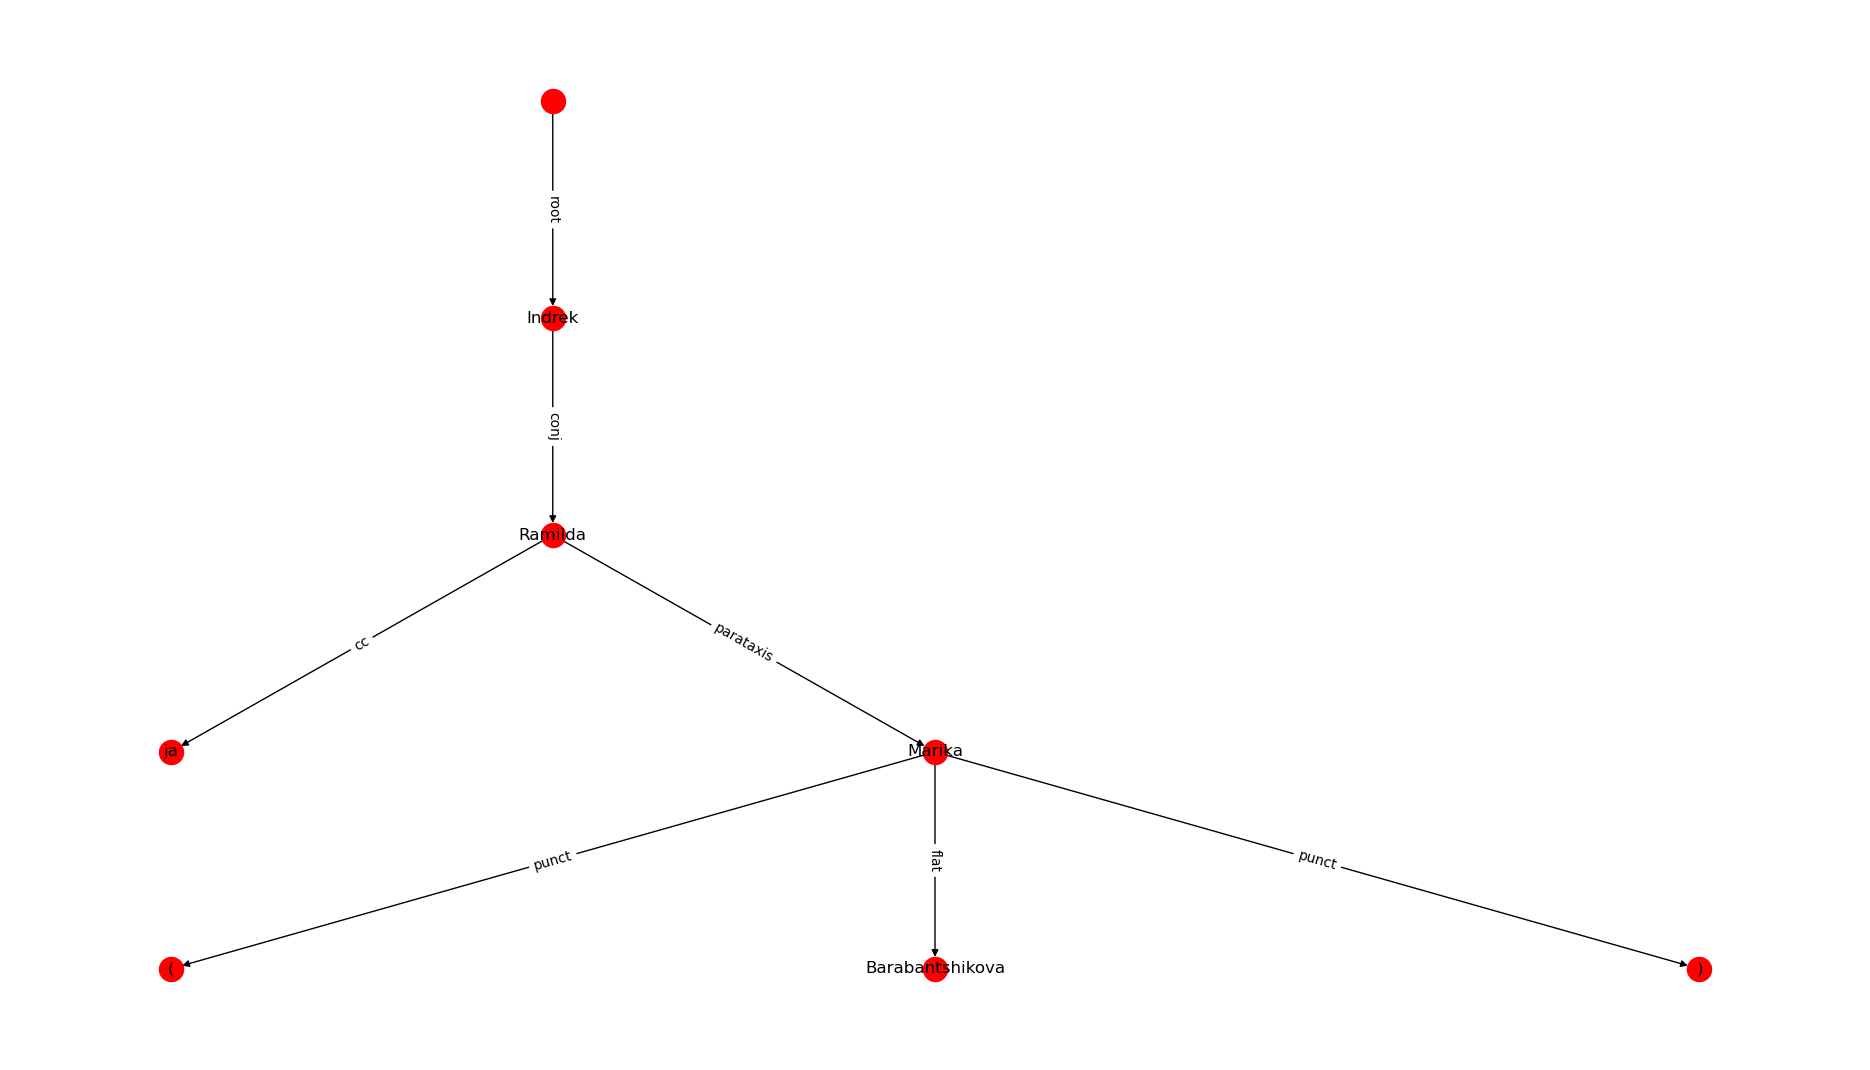

<Figure size 1850x1050 with 0 Axes>

In [20]:
# Visualiseerimine
draw_graph(test_graph, 'lemma')

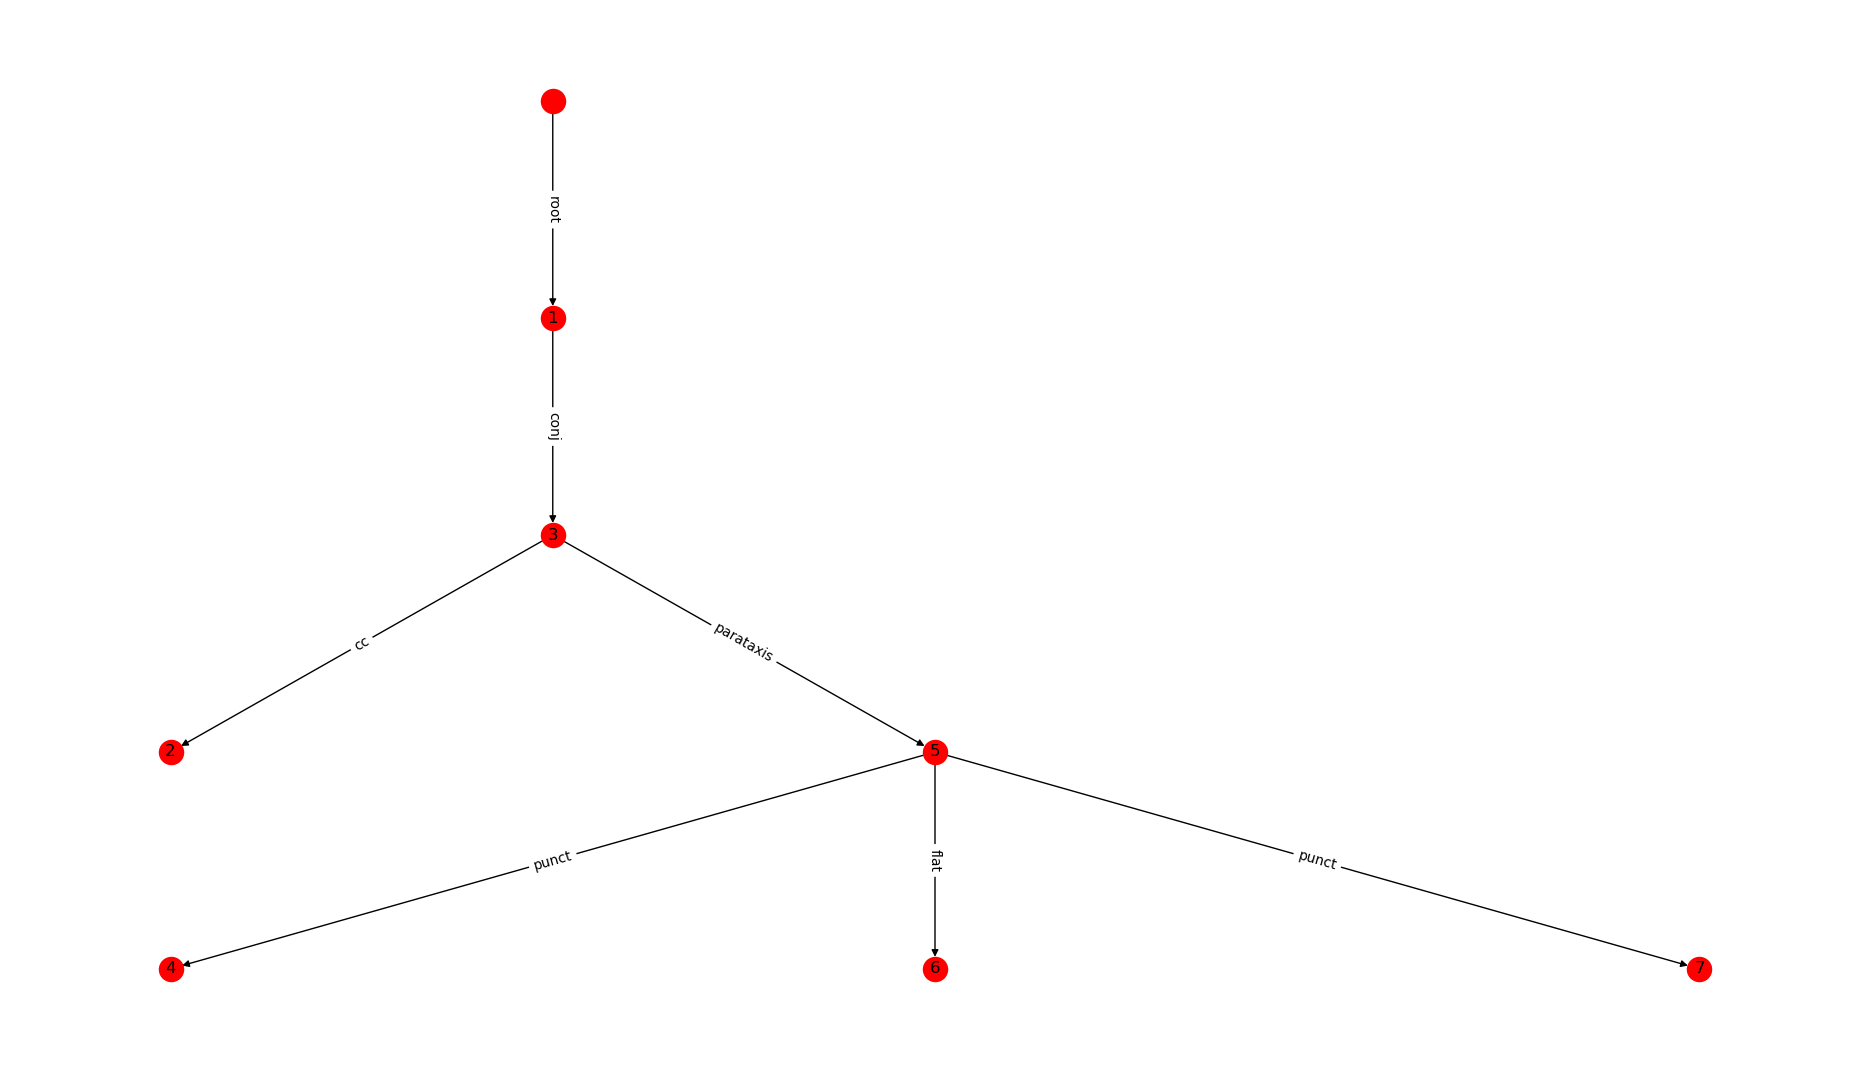

<Figure size 1850x1050 with 0 Axes>

In [21]:
draw_graph(test_graph, 'id')

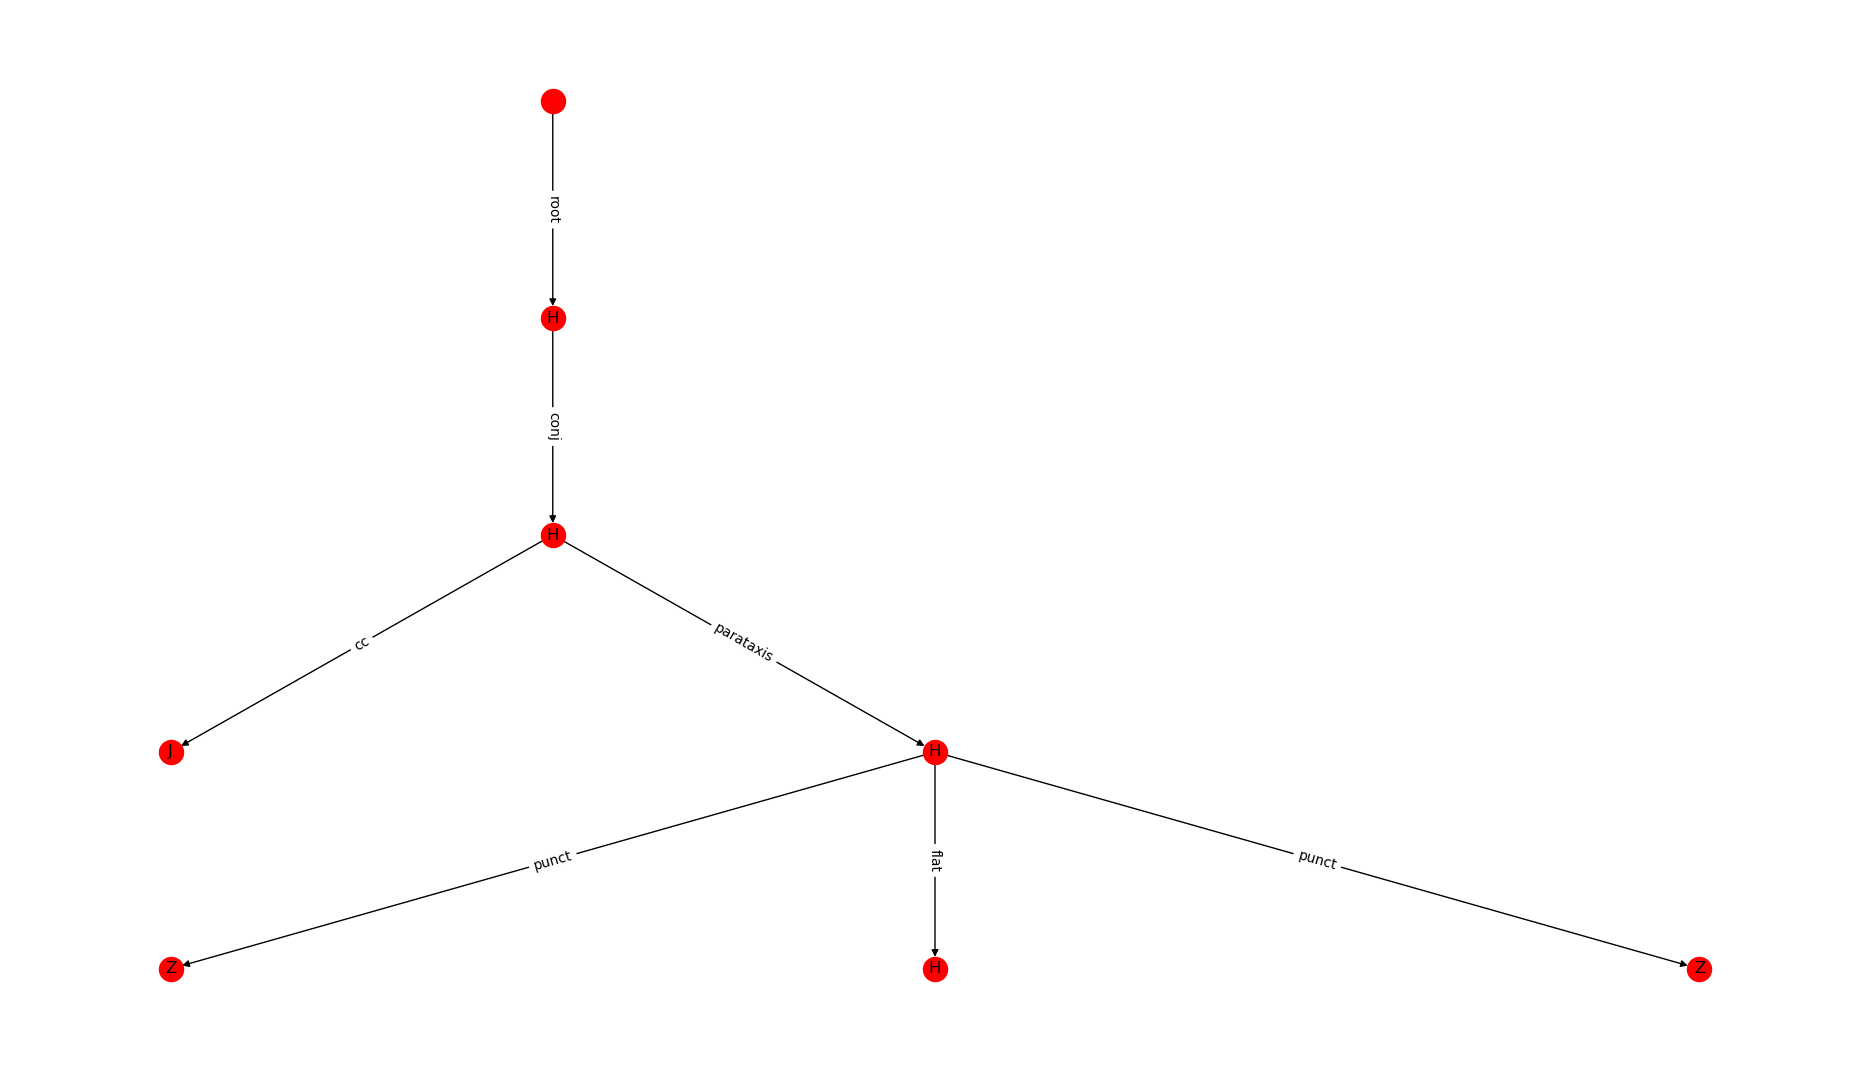

<Figure size 1850x1050 with 0 Axes>

In [22]:
draw_graph(test_graph, 'pos')

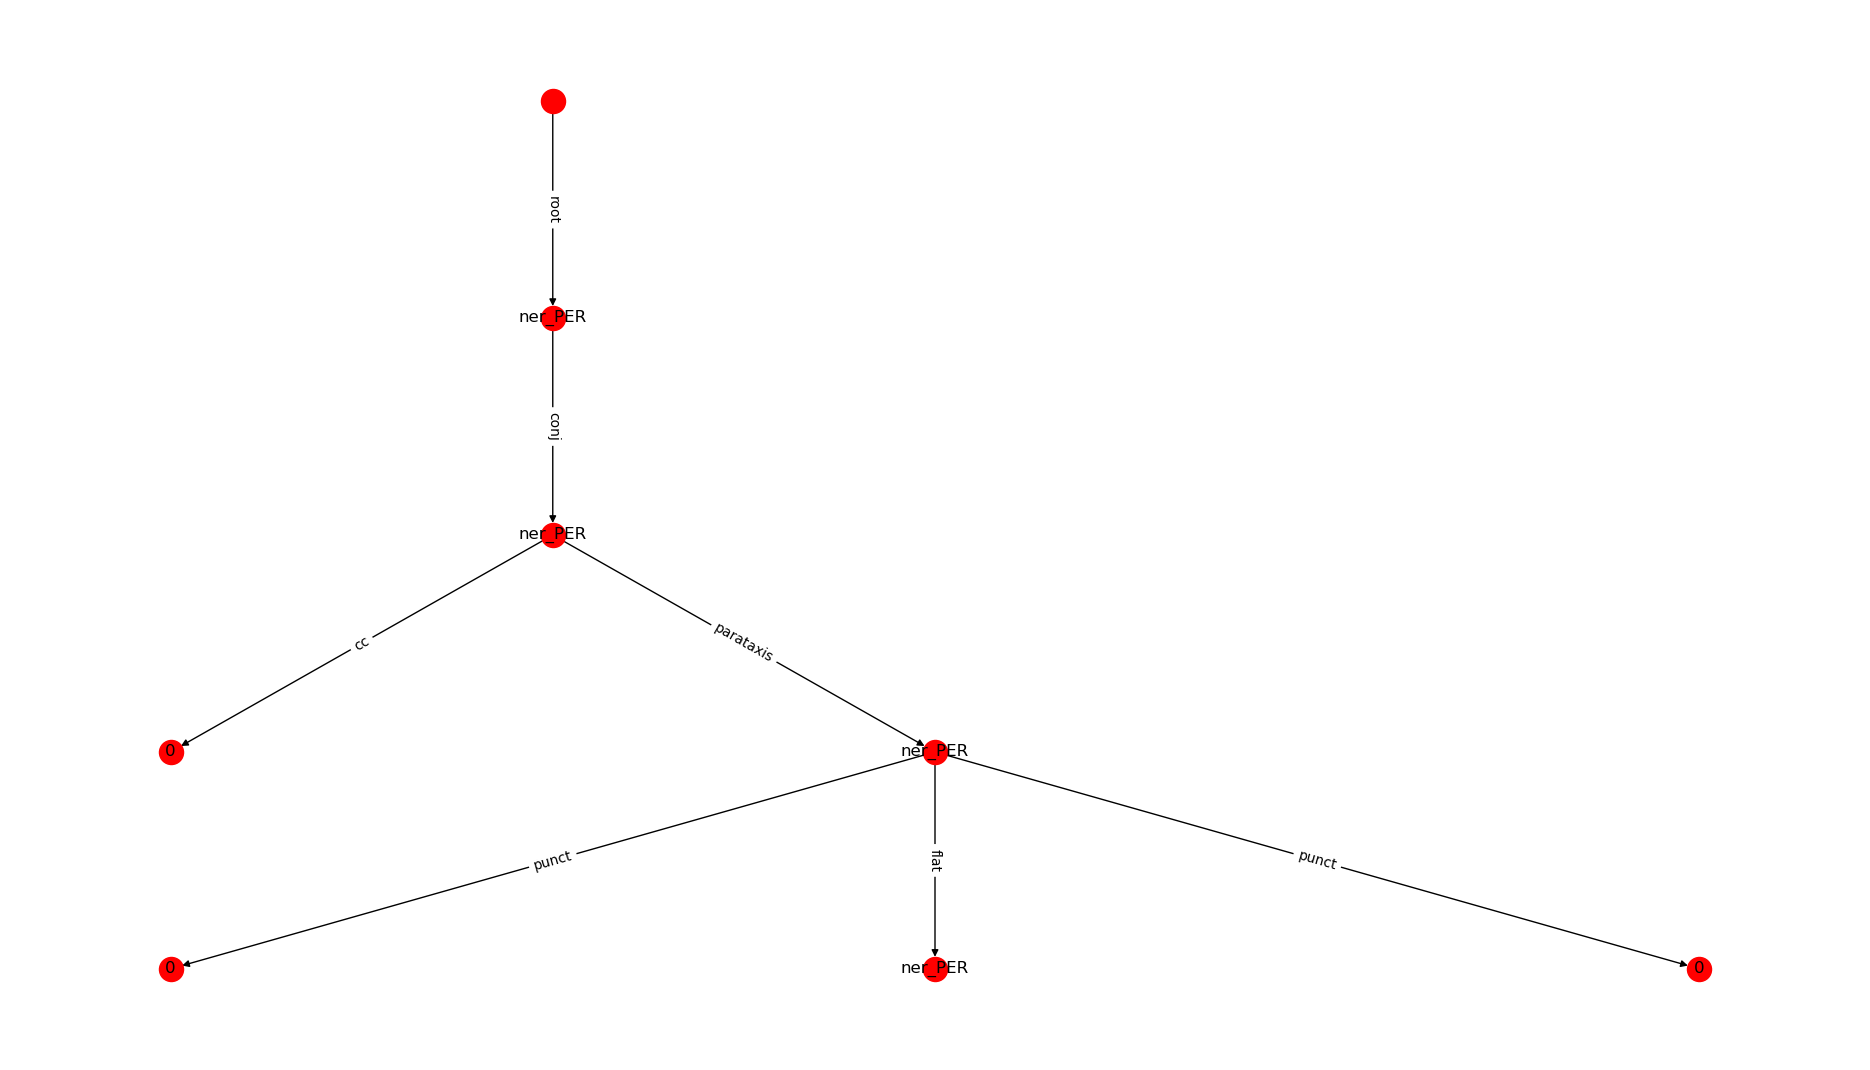

<Figure size 1850x1050 with 0 Axes>

In [23]:
draw_graph(test_graph, 'ner_timex')

Graafid ka DataFrame-i:

In [11]:
all_graphs = []
for phrase in df['phrase']:
    graph = create_graph(phrase)
    all_graphs.append(graph)
df.insert(len(df.columns), 'graph', all_graphs)

In [12]:
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence,graph
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,P,"(1, 0)"
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,D-A-S,"(1, 2, 3, 0)"
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,P-K,"(1, 0, 2)"
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,S,"(1, 0)"
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,S,"(1, 0)"
...,...,...,...,...,...,...,...,...
33734,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)"
33735,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z,"(1, 4, 2, 3, 0, 5, 6, 7, 8)"
33736,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,J-S-Z,"(1, 2, 0, 3)"
33737,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)"


Kas graaf on hashable?

In [13]:
df.duplicated(subset=['graph'], keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
33734    False
33735    False
33736    False
33737    False
33738    False
Length: 33739, dtype: bool

Kuna ei tulnud error, siis on hashable.

### DataFrame-i salvestamine

In [14]:
df.to_pickle("./noun_phrase_data.pkl") 

In [15]:
df = pd.read_pickle("./noun_phrase_data.pkl")
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence,graph
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,P,"(1, 0)"
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,D-A-S,"(1, 2, 3, 0)"
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,P-K,"(1, 0, 2)"
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,S,"(1, 0)"
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,S,"(1, 0)"
...,...,...,...,...,...,...,...,...
33734,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)"
33735,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z,"(1, 4, 2, 3, 0, 5, 6, 7, 8)"
33736,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,J-S-Z,"(1, 2, 0, 3)"
33737,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)"


### Histogramm fraasi pikkuste jagunemisest (sõnades)

In [39]:
# eri fraasitüüpide kohta eraldi histogrammid

In [40]:
all_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df))])

obl_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                               if df['phrase_type'][i]=='obl_phrase'])

nsubj_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='nsubj_phrase'])

nsubj_cop_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                     if df['phrase_type'][i]=='nsubj_cop_phrase'])

obj_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                               if df['phrase_type'][i]=='obj_phrase'])

xcomp_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='xcomp_phrase'])

nmod_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='nmod_phrase'])

appos_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='appos_phrase'])

parataxis_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='parataxis_phrase'])

root_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='root_phrase'])

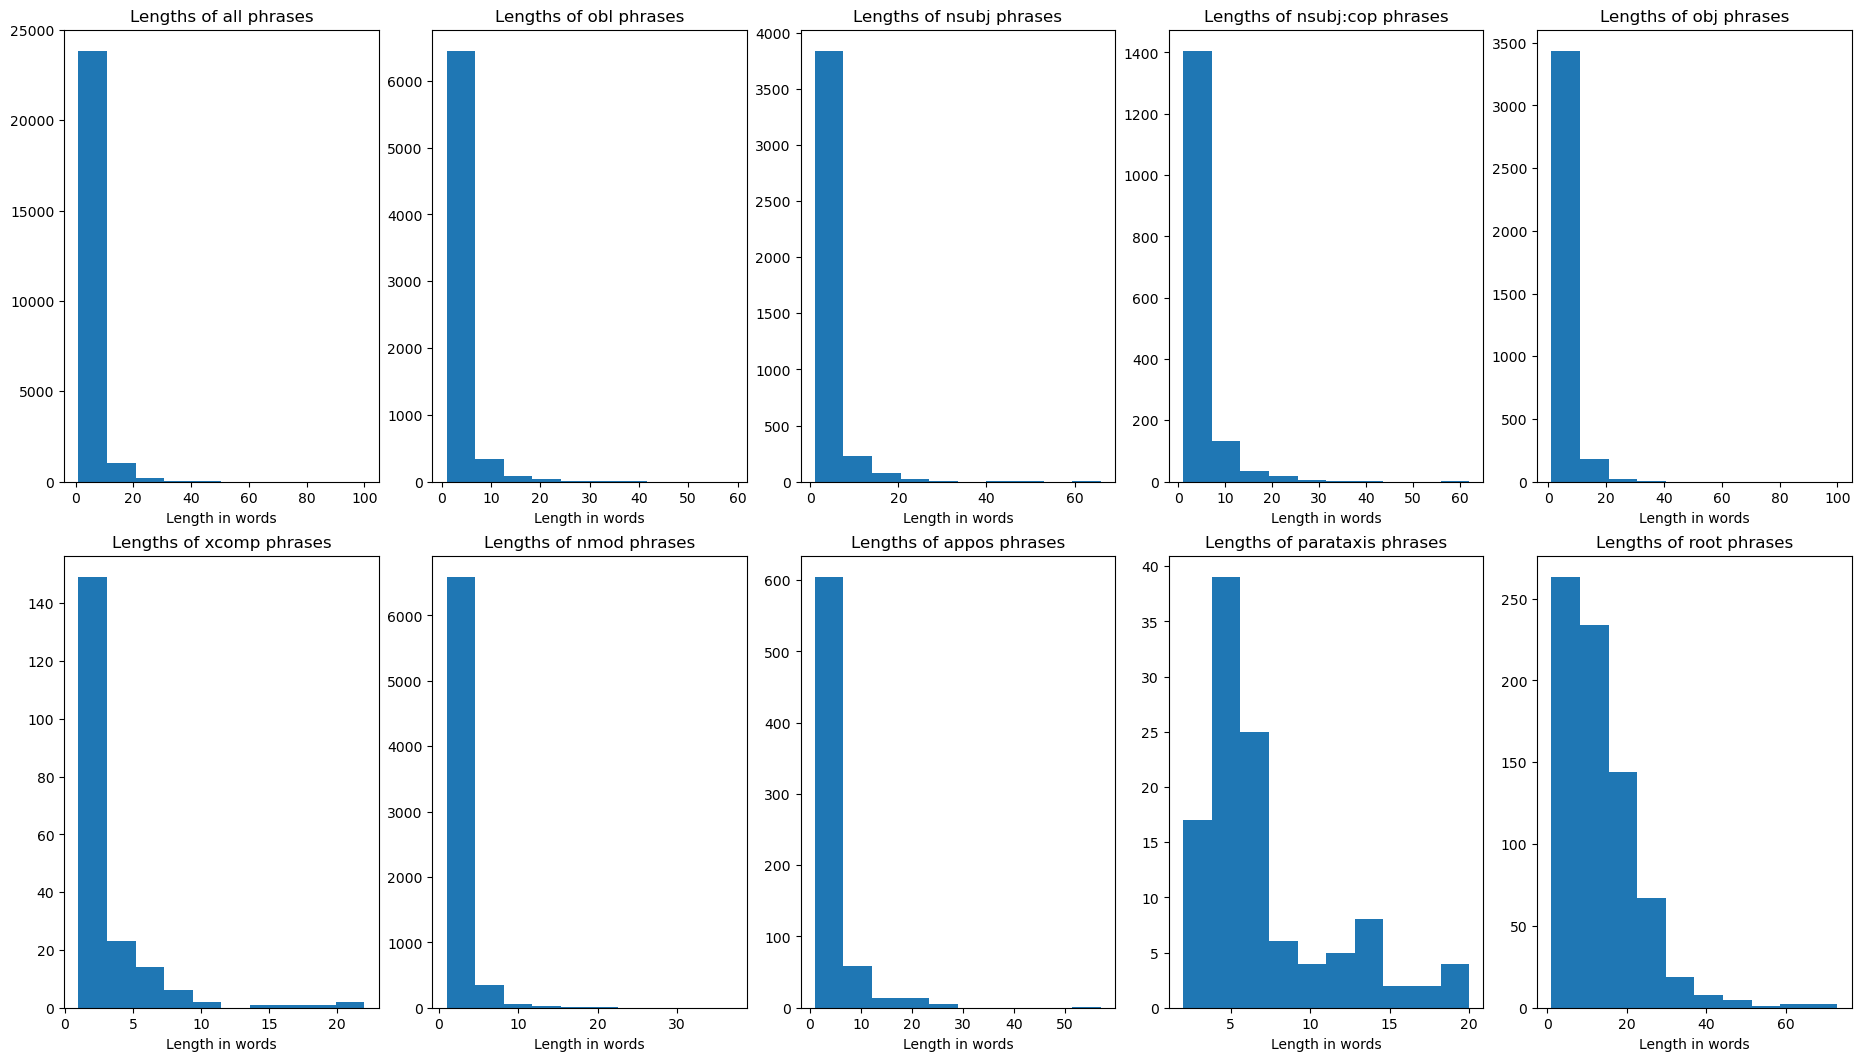

In [41]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, constrained_layout=True)
ax1.set_title('Lengths of all phrases')
ax1.set_xlabel('Length in words')
ax1.hist(all_phrase_lengths)
ax2.set_title('Lengths of obl phrases')
ax2.set_xlabel('Length in words')
ax2.hist(obl_phrase_lengths)
ax3.set_title('Lengths of nsubj phrases')
ax3.set_xlabel('Length in words')
ax3.hist(nsubj_phrase_lengths)
ax4.set_title('Lengths of nsubj:cop phrases')
ax4.set_xlabel('Length in words')
ax4.hist(nsubj_cop_phrase_lengths)
ax5.set_title('Lengths of obj phrases')
ax5.set_xlabel('Length in words')
ax5.hist(obj_phrase_lengths)
ax6.set_title('Lengths of xcomp phrases')
ax6.set_xlabel('Length in words')
ax6.hist(xcomp_phrase_lengths)
ax7.set_title('Lengths of nmod phrases')
ax7.set_xlabel('Length in words')
ax7.hist(nmod_phrase_lengths)
ax8.set_title('Lengths of appos phrases')
ax8.set_xlabel('Length in words')
ax8.hist(appos_phrase_lengths)
ax9.set_title('Lengths of parataxis phrases')
ax9.set_xlabel('Length in words')
ax9.hist(parataxis_phrase_lengths)
ax10.set_title('Lengths of root phrases')
ax10.set_xlabel('Length in words')
ax10.hist(root_phrase_lengths)
plt.show()

### Graph code ja groupby() graafidel

Graafe ei saa otse võrrelda ega grupeerida. Seetõttu loome sõne kujul graafi koodi.

In [30]:
get_graph_code(test_graph)

'((0, 1, root),(1, 3, conj),(3, 2, cc),(3, 5, parataxis),(5, 4, punct),(5, 6, flat),(5, 7, punct))'

In [31]:
get_graph_code(test_graph, ['pos'])

'(H-H-J-H-Z-H-Z,(0, 1, root),(1, 3, conj),(3, 2, cc),(3, 5, parataxis),(5, 4, punct),(5, 6, flat),(5, 7, punct))'

In [32]:
get_graph_code(test_graph, ['pos', 'ner_timex'])

'(ner_PER-ner_PER-0-ner_PER-0-ner_PER-0,H-H-J-H-Z-H-Z,(0, 1, root),(1, 3, conj),(3, 2, cc),(3, 5, parataxis),(5, 4, punct),(5, 6, flat),(5, 7, punct))'

Tehakse uued tulbad eri tüüpi koodide jaoks. Nende järgi toimubki hiljem grupeerimine.

In [16]:
df['graph_code'] = [get_graph_code(graph) for graph in df['graph']]

In [17]:
df['graph_code_pos'] = [get_graph_code(graph, ['pos']) for graph in df['graph']]

In [18]:
df['graph_code_pos_ner_timex'] = [get_graph_code(graph, ['pos', 'ner_timex']) for graph in df['graph']]

In [19]:
df.to_pickle("./noun_phrase_data.pkl") 

In [20]:
df = pd.read_pickle("./noun_phrase_data.pkl")
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence,graph,graph_code,graph_code_pos,graph_code_pos_ner_timex
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,P,"(1, 0)","((0, 1, root))","(P,(0, 1, root))","(0,P,(0, 1, root))"
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,D-A-S,"(1, 2, 3, 0)","((0, 3, root),(2, 1, advmod),(3, 2, amod))","(S-D-A,(0, 3, root),(2, 1, advmod),(3, 2, amod))","(0-0-0,S-D-A,(0, 3, root),(2, 1, advmod),(3, 2, amod))"
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,P-K,"(1, 0, 2)","((0, 1, root),(1, 2, case))","(P-K,(0, 1, root),(1, 2, case))","(0-0,P-K,(0, 1, root),(1, 2, case))"
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,S,"(1, 0)","((0, 1, root))","(S,(0, 1, root))","(0,S,(0, 1, root))"
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,S,"(1, 0)","((0, 1, root))","(S,(0, 1, root))","(0,S,(0, 1, root))"
...,...,...,...,...,...,...,...,...,...,...,...
33734,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","((0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))","(S-P-V-A-A-S-Z-V-Z-(J|D)-P-V-S-D-S-Z-J-V-S-P-C-V,(0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))","(0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,S-P-V-A-A-S-Z-V-Z-(J|D)-P-V-S-D-S-Z-J-V-S-P-C-V,(0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))"
33735,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z,"(1, 4, 2, 3, 0, 5, 6, 7, 8)","((0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))","(S-H-V-D-V-Z-S-P,(0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))","(0-ner_LOC-0-0-0-0-0-0,S-H-V-D-V-Z-S-P,(0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))"
33736,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,J-S-Z,"(1, 2, 0, 3)","((0, 2, root),(2, 1, cc),(2, 3, punct))","(S-J-Z,(0, 2, root),(2, 1, cc),(2, 3, punct))","(0-0-0,S-J-Z,(0, 2, root),(2, 1, cc),(2, 3, punct))"
33737,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","((0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))","(S-P-K-V-P-V-Z-D-V-Z-J-P,(0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))","(0-0-0-0-0-0-0-0-0-0-0-0,S-P-K-V-P-V-Z-D-V-Z-J-P,(0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))"


Grupeerides ainult ID-de alusel:

In [23]:
# grupeerides ainul ID-de alusel
grouped_df2 = df.groupby('graph_code')

In [24]:
grouped_df2.describe()

phrase  \
                                                                                                                                                                                                                                                                                                              count   
graph_code                                                                                                                                                                                                                                                                                                            
((0, 1, root))                                                                                                                                                                                                                                                                                                14896   
((0, 1, root),(0, 2, root),(2, 1, amod))                                                                                                                                                                                                                                                                          1   
((0, 1, root),(0, 3, root),(2, 1, amod),(3, 2, nmod))                                                                                                                                                                                                                                                             1   
((0, 1, root),(1, 10, acl),(1, 11, punct),(6, 5, det),(7, 8, case),(9, 7, obl),(10, 2, punct),(10, 3, advmod),(10, 4, obl),(10, 6, nsubj),(10, 9, xcomp))                                                                                                                                                         2   
((0, 1, root),(1, 10, acl),(4, 2, det),(4, 3, amod),(5, 4, obl),(6, 5, acl),(7, 6, nmod),(9, 8, amod),(10, 7, obl),(10, 9, obj))                                                                                                                                                                                  1   
...                                                                                                                                                                                                                                                                                                             ...   
((0, 9, root),(4, 2, nmod),(4, 3, punct),(4, 6, conj),(4, 7, punct),(6, 5, cc),(9, 1, punct),(9, 4, nmod),(9, 8, amod),(9, 10, nmod),(9, 13, nmod),(13, 11, punct),(13, 12, punct),(13, 14, punct))                                                                                                               1   
((0, 9, root),(4, 6, conj),(6, 5, cc),(9, 1, cc),(9, 2, xcomp),(9, 3, punct),(9, 4, nsubj:cop),(9, 7, aux),(9, 8, cop),(9, 19, obl),(9, 20, punct),(10, 12, conj),(12, 11, cc),(16, 15, nmod),(17, 16, obl),(18, 17, acl),(19, 10, nmod),(19, 13, punct),(19, 14, advmod),(19, 18, nmod))                         1   
((0, 9, root),(5, 4, advmod),(6, 5, amod),(6, 8, conj),(8, 3, cc),(8, 7, cc),(9, 1, case),(9, 2, acl),(9, 6, amod))                                                                                                                                                                                               1   
((0, 9, root),(7, 6, advmod),(8, 7, advmod),(9, 1, obl),(9, 2, cop),(9, 3, advmod),(9, 4, nsubj:cop),(9, 5, nmod),(9, 8, acl),(9, 10, case),(9, 12, conj),(9, 20, punct),(12, 11, punct),(12, 15, xcomp),(15, 13, obj),(15, 14, compound:prt),(15, 19, conj),(18, 17, advmod),(19, 16, cc),(19, 18, advmod))      1   
((0, 9, root),(9, 1, cc),(9, 2, advmod),(9, 3, aux),(9, 4, nsubj:cop),(9, 5, cop),(9, 6, advmod),(9, 7, det),(9, 8, amod),(9, 10, obl),(9, 11, punct))                                                                                                            

Grupeerides ID-de ja POS-järjestuste alusel:

In [25]:
# grupeerides ID-de ja POS-järjestuste alusel
grouped_df3 = df.groupby(['graph_code_pos'])

In [26]:
grouped_df3.describe()

phrase  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                count   
graph_code_pos                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
((A|V)-D-D-S-S-H-S-A-S-S-H-K-S,(0, 4, root),(3, 2, advmod),(4, 1, obl),(4, 3, advmod),(4, 8, obl),(6, 5, nmod),(8, 6, nmod),(8, 7, amod),(8, 10, nmod),(8, 13, nmod),(10, 9, nmod),(13, 11, case),(13, 12, nmod))                                                                                                                                                                                                                                                   

Grupeerides ID-de ja ner/timex entiteetide alusel:

In [27]:
# grupeerides ID-de ja ner/timex entiteetide alusel
grouped_df4 = df.groupby(['graph_code_pos_ner_timex'])

In [28]:
grouped_df4.describe()

phrase  \
                                                                                                                                                                                                                                                                                                                                                count   
graph_code_pos_ner_timex                                                                                                                                                                                                                                                                                                                                
(0,(P|N),(0, 1, root))                                                                                                                                                                                                                                                                                                                              9   
(0,(P|O),(0, 1, root))                                                                                                                                                                                                                                                                                                                             22   
(0,A,(0, 1, root))                                                                                                                                                                                                                                                                                                                                109   
(0,C,(0, 1, root))                                                                                                                                                                                                                                                                                                                                  6   
(0,D,(0, 1, root))                                                                                                                                                                                                                                                                                                                                  8   
...                                                                                                                                                                                                                                                                                                                                               ...   
(timex-ner_LOC,S-H,(0, 2, root),(2, 1, nmod))                                                                                                                                                                                                                                                                                                       1   
(timex-ner_ORG-0-0-0,H-Y-S-Z-Z,(0, 1, root),(1, 3, nmod),(1, 5, appos),(3, 2, punct),(5, 4, punct))                                                                                                                                                                                                                                                 2   
(timex-ner_PER-ner_PER-0-0-0-ner_LOC-0-0-0-0-0-0-0-0-0-0,S-H-H-S-S-N-H-V-S-Z-S-S-Z-S-S-Z-J,(0, 8, root),(1, 2, flat),(3, 1, nmod),(4, 3, nmod),(4, 6, nummod),(6, 5, nmod),(8, 4, obl),(8, 7, cop),(8, 10, nsubj:cop),(8, 17, punct),(10, 9, nmod),(10, 12, appos),(12, 11, punct),(12, 14, conj),(12, 16, conj),(14, 13, punct),(16, 15, cc))      1   
(timex-timex-0,S-S-J,(0, 1, root),(1, 3, conj),(3, 2, cc))                                                                                                                                         

Grupid ja nende liikmed:

In [118]:
# grupeeritud ID-de ja ner/timex entiteetide alusel
#for name, group in grouped_df4:
#    display(name, group, len(group))

In [60]:
#for name, group in grouped_df4:
#    print(name, len(group))
#    print()

### Groupby() fraasipikkuse ja sõnaliigijärjestuse alusel

In [32]:
phrase_lengths = [len(df['phrase'][i].words) for i in range(len(df))]

df.insert(1, 'phrase_length', phrase_lengths) 

In [33]:
df

,phrase,phrase_length,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence,graph,graph_code,graph_code_pos,graph_code_pos_ner_timex
0,Text(text='Minu'),1,0,"(25, 29)",obl_phrase,0,0,P,"(1, 0)","((0, 1, root))","(P,(0, 1, root))","(0,P,(0, 1, root))"
1,Text(text='täiesti õigel kohal'),3,0,"(119, 138)",obl_phrase,0,0,D-A-S,"(1, 2, 3, 0)","((0, 3, root),(2, 1, advmod),(3, 2, amod))","(S-D-A,(0, 3, root),(2, 1, advmod),(3, 2, amod))","(0-0-0,S-D-A,(0, 3, root),(2, 1, advmod),(3, 2, amod))"
2,Text(text='mille kohaselt'),2,0,"(187, 201)",obl_phrase,0,0,P-K,"(1, 0, 2)","((0, 1, root),(1, 2, case))","(P-K,(0, 1, root),(1, 2, case))","(0-0,P-K,(0, 1, root),(1, 2, case))"
3,Text(text='parlamenti'),1,0,"(210, 220)",obl_phrase,0,0,S,"(1, 0)","((0, 1, root))","(S,(0, 1, root))","(0,S,(0, 1, root))"
4,Text(text='valimistel'),1,0,"(326, 336)",obl_phrase,0,0,S,"(1, 0)","((0, 1, root))","(S,(0, 1, root))","(0,S,(0, 1, root))"
...,...,...,...,...,...,...,...,...,...,...,...,...
33734,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",22,145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","((0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))","(S-P-V-A-A-S-Z-V-Z-(J|D)-P-V-S-D-S-Z-J-V-S-P-C-V,(0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))","(0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,S-P-V-A-A-S-Z-V-Z-(J|D)-P-V-S-D-S-Z-J-V-S-P-C-V,(0, 5, root),(5, 1, nsubj:cop),(5, 2, cop),(5, 3, amod),(5, 4, amod),(5, 16, conj),(5, 22, punct),(9, 6, punct),(9, 7, mark),(9, 8, nsubj),(9, 10, xcomp),(10, 11, obl),(10, 12, advmod),(10, 13, obj),(16, 9, advcl),(16, 14, punct),(16, 15, advmod),(16, 17, cop),(16, 20, nsubj:cop),(19, 18, obl),(20, 19, amod),(20, 21, acl))"
33735,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),8,145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z,"(1, 4, 2, 3, 0, 5, 6, 7, 8)","((0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))","(S-H-V-D-V-Z-S-P,(0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))","(0-ner_LOC-0-0-0-0-0-0,S-H-V-D-V-Z-S-P,(0, 4, root),(4, 1, obl),(4, 2, cop),(4, 3, advmod),(4, 5, csubj:cop),(4, 8, punct),(5, 7, obl),(7, 6, det))"
33736,Text(text='Aga publikule ?'),3,145,"(4692, 4707)",root_phrase,0,0,J-S-Z,"(1, 2, 0, 3)","((0, 2, root),(2, 1, cc),(2, 3, punct))","(S-J-Z,(0, 2, root),(2, 1, cc),(2, 3, punct))","(0-0-0,S-J-Z,(0, 2, root),(2, 1, cc),(2, 3, punct))"
33737,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",12,145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","((0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))","(S-P-K-V-P-V-Z-D-V-Z-J-P,(0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp))","(0-0-0-0-0-0-0-0-0-0-0-0,S-P-K-V-P-V-Z-D-V-Z-J-P,(0, 5, root),(1, 2, case),(5, 1, obl),(5, 3, cop),(5, 4, det),(5, 11, acl),(5, 12, punct),(10, 9, advmod),(11, 6, punct),(11, 7, mark),(11, 8, nsubj),(11, 10, xcomp)

In [46]:
grouped_df5 = df.groupby('phrase_length')

In [47]:
grouped_df5.describe()

phrase         \
               count unique   
phrase_length                 
1              14893  14893   
2               8108   8108   
3               3759   3759   
4               1850   1850   
5               1068   1068   
6                775    775   
7                523    523   
8                398    398   
9                338    338   
10               274    274   
11               246    246   
12               199    199   
13               195    195   
14               152    152   
15               143    143   
16               101    101   
17               108    108   
18                78     78   
19                69     69   
20                78     78   
21                50     50   
22                50     50   
23                39     39   
24                32     32   
25                26     26   
26                25     25   
27                25     25   
28                16     16   
29                14     14   
30                11     11   
31                14     14   
32                12     12   
33                 7      7   
34                 5      5   
35                 3      3   
36                 2      2   
37                 4      4   
38                 4      4   
39                 3      3   
40                 4      4   
41                 2      2   
43                 2      2   
44                 2      2   
46                 3      3   
47                 4      4   
48                 1      1   
49                 3      3   
51                 1      1   
55                 1      1   
57                 2      2   
58                 2      2   
59                 2      2   
61                 2      2   
62                 2      2   
64                 1      1   
65                 2      2   
66                 3      3   
73                 2      2   
100                1      1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         top   
phrase_length                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                                                                                                                                                                                          

In [48]:
grouped_df5.size().reset_index(name='count').sort_values(['count'], ascending=False)

,phrase_length,count
0,1,14893
1,2,8108
2,3,3759
3,4,1850
4,5,1068
5,6,775
6,7,523
7,8,398
8,9,338
9,10,274


In [ ]:
# Andmete salvestamine CSV-formaati (aga nii lähevad kaduma graafid)
directory = 'phrase_groups'

if not os.path.isdir(directory):
    os.mkdir(directory)

# -- target directory path
directory_path = 'phrase_groups/'

for name, group in grouped_df5:
    group.to_csv(directory_path+'phrases_len_{}.csv'.format(name))

In [52]:
# Andmete salvestamine pickle-formaati (graafid jäävad alles)
directory = 'phrase_groups_df'

if not os.path.isdir(directory):
    os.mkdir(directory)

# -- target directory path
directory_path = 'phrase_groups_df/'

for name, group in grouped_df5:
    group.to_pickle(directory_path+'phrases_len_{}.pkl'.format(name))